# Challenge Credit Risk

**Packages**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#from datetime import date, datetime

In [2]:
#plt.rcParams['figure.figsize'] = [8,5]
#plt.rcParams['font.size'] =14
#plt.rcParams['font.weight']= 'bold'
#plt.style.use('seaborn-whitegrid')

## Business Undestanding

### Questions to answer 

- Pick the best clients you will give a loan to, based on the model you created. It
could be as complex as you decide (even as simpler as knock out rules), as long as
the metrics support it
- Propose an amount to be lended to those clients and a term in which the loan will
need to be paid back.
- Finally choose an anual interest rate the lended amount must have in order to be
profitable.

## Data Understanding

Read datasets

In [3]:
from pathlib import Path
root_dir = Path().resolve()

In [4]:
data_users = pd.read_csv('data/users.csv')
data_credit_reports = pd.read_csv('data/credit_reports.csv', parse_dates=['account_opening_date', 'account_closing_date'])

### Solving the date's format
The dataset `data_credit_reports` has '0000-00-00' values in the column `worst_delinquency_date`, probably due to an error in the date's conversion during the data preparation.

In [5]:
data_credit_reports['worst_delinquency_date'].loc[data_credit_reports['worst_delinquency_date'].str.match('.*\/.*\/.*') == False]

16       0000-00-00
22       0000-00-00
23       0000-00-00
354      0000-00-00
355      0000-00-00
            ...    
15642    0000-00-00
15884    0000-00-00
15885    0000-00-00
15898    0000-00-00
15899    0000-00-00
Name: worst_delinquency_date, Length: 428, dtype: object

In [6]:
data_credit_reports['worst_delinquency_date'].replace({"0000-00-00": np.NaN}, inplace=True)
data_credit_reports['worst_delinquency_date'] = pd.to_datetime(data_credit_reports['worst_delinquency_date'], 
                                                              format='%m/%d/%y')

### Exploring user's Income and outcome 

In [7]:
data_users.head(10)

,id,monthly_income,monthly_outcome,class
0,0,255359,151439,1
1,1,8940,789,0
2,2,11436,3316,0
3,3,17143,47547,1
4,4,26990,15585,1
5,5,166,5240,0
6,6,111662,108374,1
7,7,6271,44469,1
8,8,31695,3021,0
9,9,2401260,6496313,0


In [8]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               1000 non-null   int64
 1   monthly_income   1000 non-null   int64
 2   monthly_outcome  1000 non-null   int64
 3   class            1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


#### Distribution of user's Income and outcome 

In [9]:
"""
# Set up the matplotlib figure
sns.set_palette("tab10")
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='monthly_income', data=data_users, showfliers=True, ax=axes[0])
#plt.show()

#plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='monthly_outcome', data=data_users, showfliers=True, ax=axes[1])
#plt.show()

axes1, axes2 = axes.ravel()
axes1.set_ylim(0, 0.5e6) 
axes2.set_ylim(0, 0.5e6) 

#plt.setp(axes, yticks=[])
plt.tight_layout()
"""

'\n# Set up the matplotlib figure\nsns.set_palette("tab10")\nfig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)\nfig.suptitle("Monthly Income and outcome for each user\'s class")\n\n#plt.figure(figsize=(8, 6))\nsns.boxplot(x=\'class\', y=\'monthly_income\', data=data_users, showfliers=True, ax=axes[0])\n#plt.show()\n\n#plt.figure(figsize=(8, 6))\nsns.boxplot(x=\'class\', y=\'monthly_outcome\', data=data_users, showfliers=True, ax=axes[1])\n#plt.show()\n\naxes1, axes2 = axes.ravel()\naxes1.set_ylim(0, 0.5e6) \naxes2.set_ylim(0, 0.5e6) \n\n#plt.setp(axes, yticks=[])\nplt.tight_layout()\n'

In [10]:
data_users.describe()

,id,monthly_income,monthly_outcome,class
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,499.500000,1.216138e+05,1.249657e+05,0.535000
std,288.819436,4.709416e+05,5.796281e+05,0.499023
min,0.000000,1.000000e+00,1.000000e+00,0.000000
25%,249.750000,2.691250e+03,3.397750e+03,0.000000
50%,499.500000,1.253350e+04,1.424250e+04,1.000000
75%,749.250000,5.868600e+04,5.722850e+04,1.000000
max,999.000000,9.344842e+06,9.749651e+06,1.000000


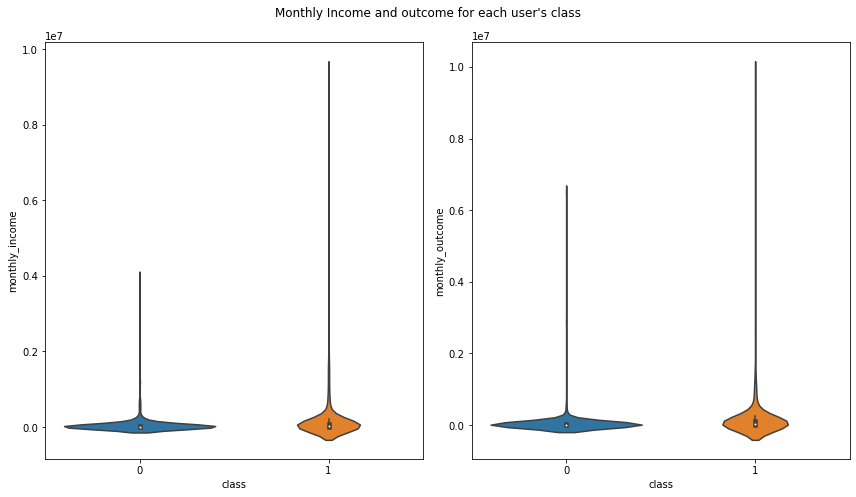

In [11]:
# Set up the matplotlib figure
sns.set_palette("tab10")
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_income', data=data_users, showfliers=True, ax=axes[0])
#plt.show()

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_outcome', data=data_users, showfliers=True, ax=axes[1])
#plt.show()

#axes1, axes2 = axes.ravel()
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 

#plt.setp(axes, yticks=[])
plt.tight_layout()

If we calculate the Fisher-Pearson standardized moment coefficient, we can see that all the variables are skewed

In [58]:
data_users[['monthly_income', 'monthly_outcome']].skew().sort_values(ascending=False)

monthly_outcome    10.895201
monthly_income     10.634858
dtype: float64

The distribution of the `monthly_income` and `monthly_outcome` variable are skewed to high values. There are some outliers.

#### Amount of each class

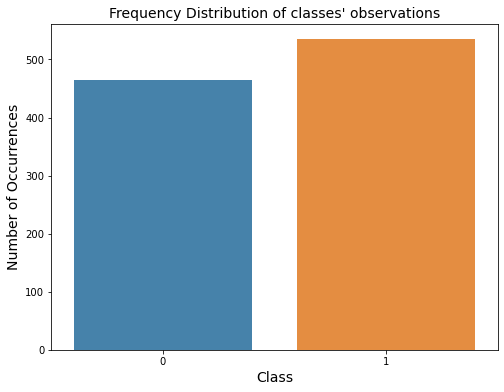

In [12]:
plt.figure(figsize=(8, 6))
class_count = pd.DataFrame(data_users['class'].value_counts())
#sns.set(style="darkgrid")
sns.barplot(x=class_count.index, y=class_count['class'],  data=class_count, alpha=0.9)
plt.title("Frequency Distribution of classes' observations", fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.show()

The number of observation in each class are balanced. There isn't an important difference between both classes. 

### Exploring user's credit reports

In [13]:
data_credit_reports.head(10)

,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
0,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,78.0,Semanal,0.0,2014-11-10,2015-12-05,9826.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
1,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,80.0,Semanal,0.0,2015-12-05,2016-10-14,16000.0,0.0,0.0,0.0,3.0,1.0,2016-05-28,200.0
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,2016-09-02,NaT,10205.0,3505.0,0.0,0.0,3.0,1.0,2017-03-03,100.0
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,2016-10-14,NaT,22920.0,11269.0,0.0,0.0,3.0,1.0,2017-03-03,191.0
4,0,KONFIO,Pagos Fijos,Préstamo Personal,12.0,Quincenal,0.0,2016-12-27,2017-06-27,150000.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
5,0,KONFIO,Pagos Fijos,Préstamo Personal,26.0,Quincenal,10825.0,2017-06-28,NaT,225000.0,159142.0,0.0,0.0,0.0,0.0,NaT,0.0
6,0,TELEFONIA CELULAR,Revolvente,Línea de Crédito,1000.0,Mensual,0.0,2016-10-06,2017-09-15,0.0,0.0,999.0,0.0,7.0,4.0,2017-05-31,4342.0
7,0,MERCANCIA PARA HOGAR Y OFICINA,Sin Límite Preestablecido,Crédito Personal al Consumo,0.0,Semanal,0.0,2014-11-10,NaT,0.0,0.0,0.0,0.0,0.0,0.0,NaT,0.0
8,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,72.0,Mensual,5874.0,2017-08-22,NaT,513069.0,475245.0,513069.0,0.0,0.0,0.0,NaT,0.0
9,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,24.0,Mensual,10557.0,2017-01-31,NaT,247705.0,124316.0,247705.0,0.0,0.0,0.0,NaT,0.0


In [14]:
data_credit_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   user_id                             16309 non-null  int64         
 1   institution                         16309 non-null  object        
 2   account_type                        16309 non-null  object        
 3   credit_type                         16309 non-null  object        
 4   total_credit_payments               16268 non-null  float64       
 5   payment_frequency                   16308 non-null  object        
 6   amount_to_pay_next_payment          16304 non-null  float64       
 7   account_opening_date                16309 non-null  datetime64[ns]
 8   account_closing_date                9068 non-null   datetime64[ns]
 9   maximum_credit_amount               16307 non-null  float64       
 10  current_balance       

In [15]:
data_credit_reports.describe()

,user_id,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,16309.000000,16268.000000,1.630400e+04,1.630700e+04,1.630400e+04,1.629600e+04,1.630400e+04,16297.000000,16255.000000,1.629700e+04
mean,474.067631,22.405766,2.779242e+03,3.994739e+04,1.993377e+04,2.398115e+04,3.618910e+03,2.291219,1.541618,1.617189e+03
std,293.165091,77.413143,2.145046e+04,1.337402e+05,1.067213e+05,9.429967e+04,2.816734e+04,8.250868,6.816558,2.845180e+04
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,213.000000,0.000000,0.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,466.000000,1.000000,0.000000e+00,6.899000e+03,0.000000e+00,8.925000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00
75%,726.000000,16.000000,5.830000e+02,2.634750e+04,3.224250e+03,1.440600e+04,0.000000e+00,0.000000,0.000000,0.000000e+00
max,999.000000,1800.000000,1.263964e+06,4.883200e+06,4.697583e+06,3.269355e+06,1.915973e+06,96.000000,84.000000,3.234351e+06


#### Missing Values

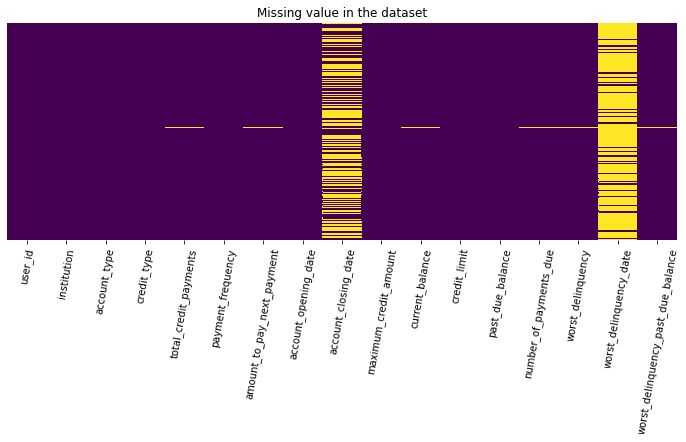

In [16]:
plt.figure(figsize=(12, 4))
sns.heatmap(data_credit_reports.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.xticks(rotation=80) 
plt.title('Missing value in the dataset');

We can see that the `account_closing_date` and `worst_delinquency_date` variables have a lot of missing values.

#### Categorical variables

In [17]:
data_credit_reports.describe(include=['object', 'bool'])

,institution,account_type,credit_type,payment_frequency
count,16309,16309,16309,16308
unique,54,8,26,10
top,BANCO,Pagos Fijos,Préstamo Personal,Mensual
freq,4285,8083,5717,11191


In [18]:
institution_count = pd.DataFrame(data_credit_reports['institution'].value_counts())
institution_count = institution_count.reset_index()

account_type_count = pd.DataFrame(data_credit_reports['account_type'].value_counts())
account_type_count = account_type_count.reset_index()

credit_type_count = pd.DataFrame(data_credit_reports['credit_type'].value_counts())
credit_type_count = credit_type_count.reset_index()

payment_frequency_count = pd.DataFrame(data_credit_reports['payment_frequency'].value_counts())
payment_frequency_count = payment_frequency_count.reset_index()

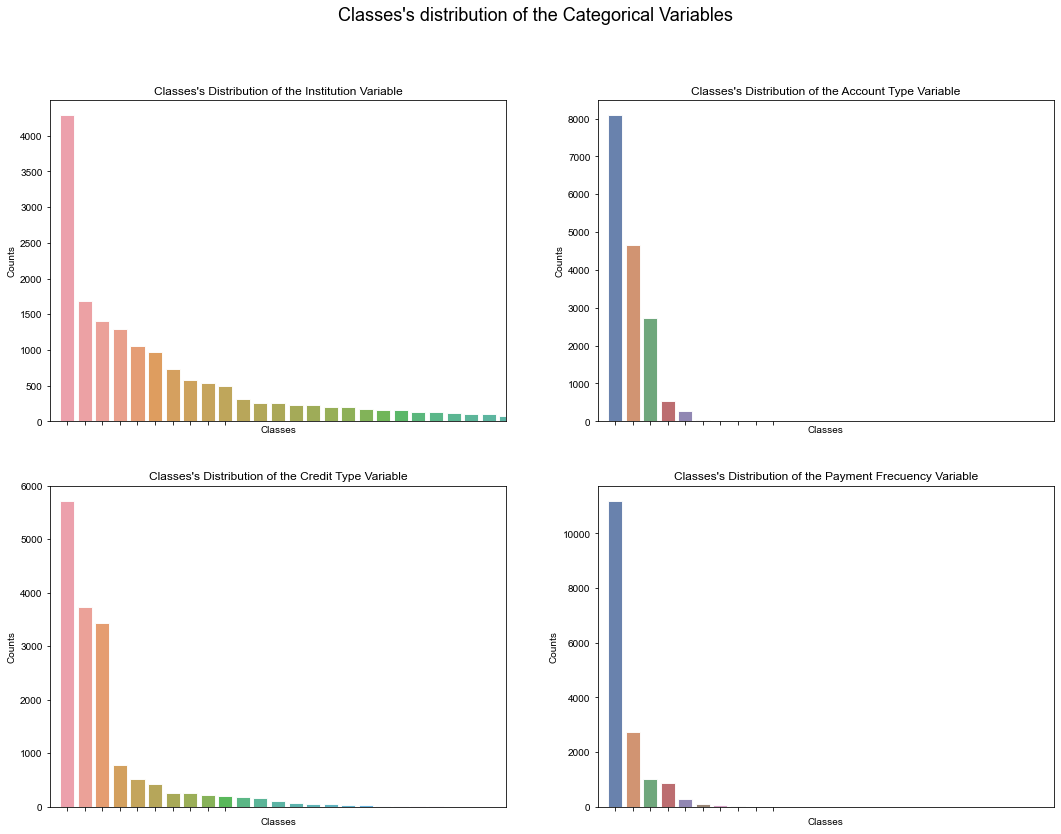

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(18, 13), sharex=True)
fig.suptitle("Classes's distribution of the Categorical Variables", size=18)

sns.set(style="darkgrid")

p1 = sns.barplot(x=institution_count['index'], y='institution',  data=institution_count, alpha=0.9, ax=axes[0,0])
#p1.set(xlabel=None)
p1.set(xticklabels=[])  
p1.set(xlabel='Classes', ylabel='Counts')
p1.set(title="Classes's Distribution of the Institution Variable")

p2 = sns.barplot(x=account_type_count['index'], y='account_type',  data=account_type_count, alpha=0.9, ax=axes[0,1])
p2.set(xticklabels=[])
p2.set(xlabel='Classes', ylabel='Counts')
p2.set(title="Classes's Distribution of the Account Type Variable")

p3 = sns.barplot(x=credit_type_count['index'], y='credit_type',  data=credit_type_count, alpha=0.9, ax=axes[1,0])
p3.set(xticklabels=[])
p3.set(xlabel='Classes', ylabel='Counts')
p3.set(title="Classes's Distribution of the Credit Type Variable")

p4 = sns.barplot(x=payment_frequency_count['index'], y='payment_frequency',  data=payment_frequency_count, alpha=0.9, ax=axes[1,1])
p4.set(xticklabels=[])  
p4.set(xlabel='Classes', ylabel='Counts')
p4.set(title="Classes's Distribution of the Payment Frecuency Variable")

axes1, axes2, axes3, axes4 = axes.ravel()
axes1.set_xlim(-1, 25)
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 
#plt.set(xlabel=None)

#plt.setp(axes, yticks=[])
#plt.tight_layout()
plt.show()

There is a problem of High cardinality and imbalanced classes, specially in the `institution`, `account_type` and `payment_frecuency` variables.

#### Quantitative variables

<ipython-input-20-f1dbe81d1499>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_credit_reports[["total_credit_payments",


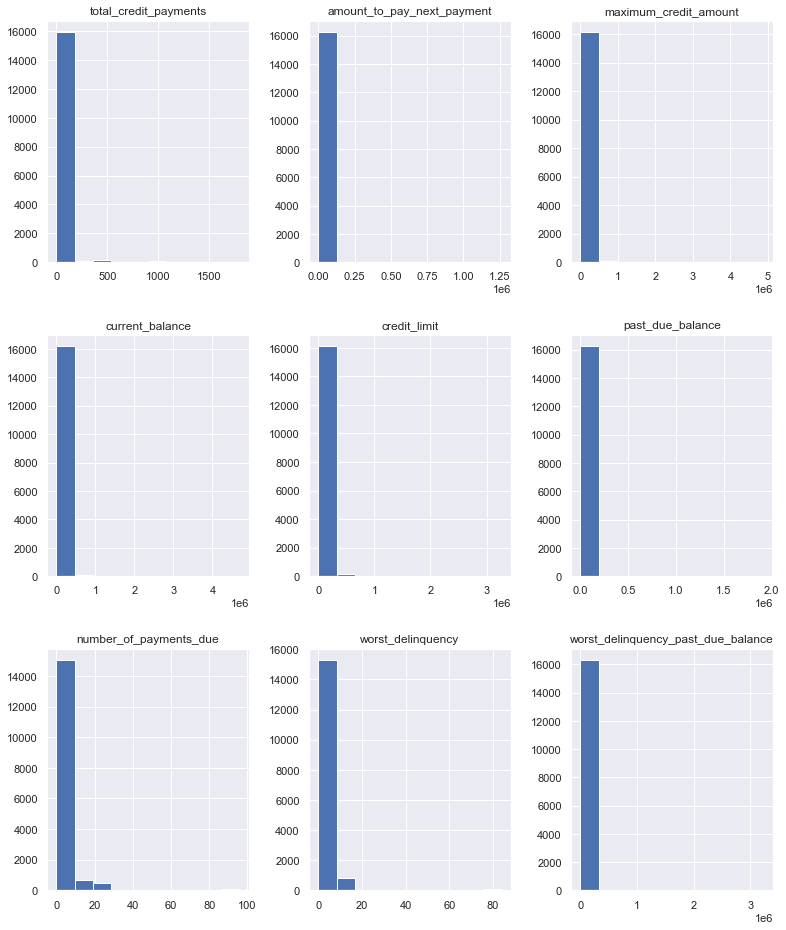

In [20]:
fig = plt.figure(figsize = (13,16))
ax = fig.gca()
#df.hist(ax = ax)
data_credit_reports[["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]].hist(ax=ax)
plt.show()

If we calculate the Fisher-Pearson standardized moment coefficient, we can see that all the variables are skewed

In [61]:
variables = ["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]

data_credit_reports[variables].skew().sort_values(ascending=False)

worst_delinquency_past_due_balance    92.203928
past_due_balance                      29.371754
amount_to_pay_next_payment            28.750662
current_balance                       17.921639
credit_limit                          15.164412
maximum_credit_amount                 13.563707
total_credit_payments                  9.638661
worst_delinquency                      8.683708
number_of_payments_due                 7.244236
dtype: float64

## Data Preparation

In [317]:
data1 = data_users.copy()
data2 = data_credit_reports.copy()

### Remove the columns with a high amount of missing values

The variables with a high number of missing values won't provided enough information to the model

In [318]:
mask = data_credit_reports.isna().sum() / len(data_credit_reports) < 0.3
data_credit_reports = data_credit_reports.loc[:, mask]

### Clone to practice 

In [395]:
data1 = data_users.copy()
data2 = data_credit_reports.copy()

In [375]:
data2.head()

,user_id,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
0,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,78.0,Semanal,0.0,2014-11-10,9826.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,80.0,Semanal,0.0,2015-12-05,16000.0,0.0,0.0,0.0,3.0,1.0,200.0
2,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,102.0,Semanal,100.0,2016-09-02,10205.0,3505.0,0.0,0.0,3.0,1.0,100.0
3,0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,120.0,Semanal,191.0,2016-10-14,22920.0,11269.0,0.0,0.0,3.0,1.0,191.0
4,0,KONFIO,Pagos Fijos,Préstamo Personal,12.0,Quincenal,0.0,2016-12-27,150000.0,0.0,0.0,0.0,0.0,0.0,0.0


### Treating categorical variables in `data_credit_reports`

There are a high number of classes in the categorical variables, and many of them don't provide us with enough information because of their low number of observations. For this reason, it is a better option to group the classes with low frequency in an unique class.

In [460]:
def createDataToNewColumn(values_to_scan, classes):
    data_to_new_column = list()
    for i in values_to_scan:
        if ((i == classes).any()):
            data_to_new_column.append(i)
        else:
            data_to_new_column.append('Other')
    return data_to_new_column

Group the classes of the variable `institution`

In [461]:
classes = institution_count[institution_count.institution > institution_count.institution.quantile(0.80)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['institution'], classes)
data_credit_reports.insert(1, 'institution_mod', new_column, True)
data_credit_reports.drop(['institution'], axis=1, inplace=True)

Group the classes of the variable `account_type`

In [462]:
classes = account_type_count[account_type_count.account_type > account_type_count.account_type.quantile(0.75)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['account_type'], classes)
data_credit_reports.insert(2, 'account_type_mod', new_column, True)
data_credit_reports.drop(['account_type'], axis=1, inplace=True)

Group the classes of the variable `credit_type`

In [464]:
classes = credit_type_count[credit_type_count.credit_type > credit_type_count.credit_type.quantile(0.9)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['credit_type'], classes)
data_credit_reports.insert(3, 'credit_type_mod', new_column, True)
data_credit_reports.drop(['credit_type'], axis=1, inplace=True)

Group the classes of the variable `payment_frequency`

In [465]:
classes = payment_frequency_count[payment_frequency_count.payment_frequency > payment_frequency_count.payment_frequency.quantile(0.9)]['index']#.sum()
new_column = createDataToNewColumn(data_credit_reports['payment_frequency'], classes)
data_credit_reports.insert(5, 'payment_frequency_mod', new_column, True)
data_credit_reports.drop(['payment_frequency'], axis=1, inplace=True)

### Add new columns to variables related with the `account_opening_date`

In [470]:
data_credit_reports['account_opening_year'] = data_credit_reports['account_opening_date'].dt.year
data_credit_reports['account_opening_month'] = data_credit_reports['account_opening_date'].dt.month
data_credit_reports['account_opening_week'] = data_credit_reports['account_opening_date'].dt.isocalendar().week

In [472]:
data_credit_reports.drop(['account_opening_date'], axis=1, inplace=True)

### Group the data from the users

In [447]:
agg_data2 = data2.groupby('user_id').agg({'institution_mod': [pd.Series.mode], 'account_type_mod':[pd.Series.mode]})

In [476]:
agg_data2_cate = data_credit_reports.groupby(['user_id'])['institution_mod', 'account_type_mod', 
                                            'credit_type_mod', 'payment_frequency_mod', 
                                            'account_opening_year', 'account_opening_month',
                                           'account_opening_week'].agg(lambda x: pd.Series.mode(x)[0])


<ipython-input-476-8e1e45567b75>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  agg_data2_cate = data_credit_reports.groupby(['user_id'])['institution_mod', 'account_type_mod',


In [477]:
agg_data2_cate

,institution_mod,account_type_mod,credit_type_mod,payment_frequency_mod,account_opening_year,account_opening_month,account_opening_week
user_id,,,,,,,
0,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,Mensual,2016,9,35
1,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Préstamo Personal,Other,2004,5,21
2,MERCANCIA PARA HOGAR Y OFICINA,Other,Préstamo Personal,Other,2017,7,19
3,BANCO,Pagos Fijos,Other,Mensual,2011,4,15
4,BANCO,Revolvente,Tarjeta de Crédito,Mensual,2012,5,22
...,...,...,...,...,...,...,...
995,SOCIEDAD FINANCIERA DE OBJETO MULTIPLE,Pagos Fijos,Préstamo Personal,Other,2017,9,39
996,Other,Pagos Fijos,Préstamo Personal,Mensual,2016,3,33
997,BANCOS,Pagos Fijos,Préstamo Personal,Other,2015,5,21


In [478]:
agg_data2_cate.describe(include=['object', 'bool'])

,institution_mod,account_type_mod,credit_type_mod,payment_frequency_mod
count,1000,1000,1000,1000
unique,12,3,4,2
top,BANCO,Pagos Fijos,Línea de Crédito,Mensual
freq,418,481,318,839


In [488]:
agg_data2_qua = data_credit_reports.groupby('user_id').agg({'total_credit_payments': ['mean'], 
                                              'amount_to_pay_next_payment':['mean'],
                                             'maximum_credit_amount':['mean'],
                                             'current_balance':['mean'],
                                             'credit_limit':['mean'],
                                             'past_due_balance':['mean'],
                                             'number_of_payments_due':['mean'],
                                             'worst_delinquency':['mean'],
                                             'worst_delinquency_past_due_balance':['mean']})

<ipython-input-489-026e1377fb11>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  agg_data2_qua[["total_credit_payments",


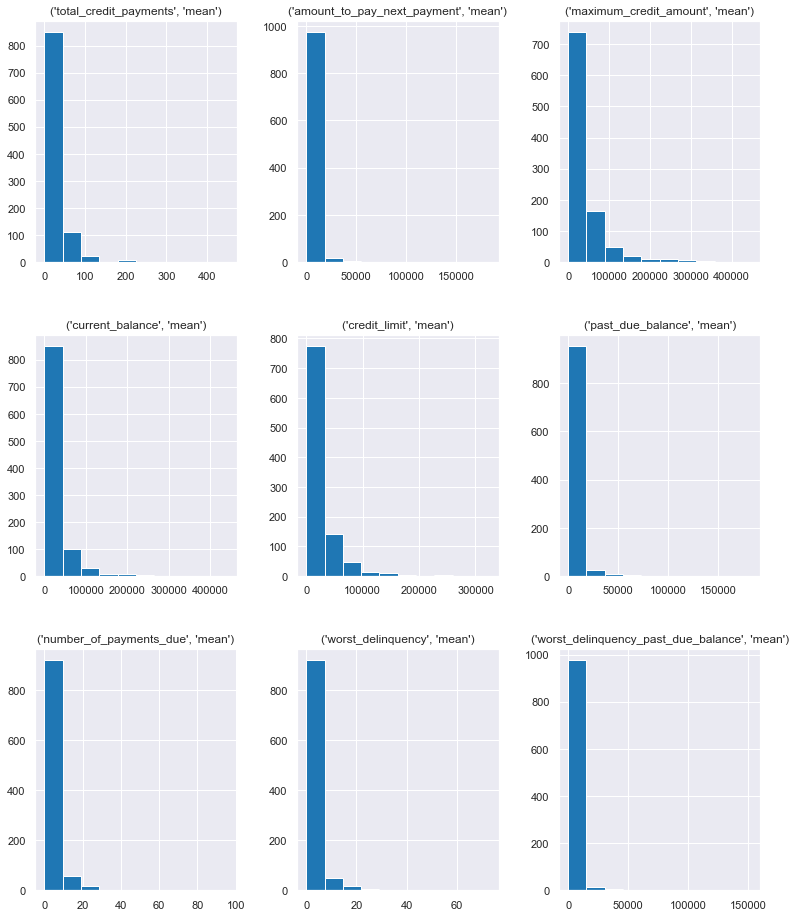

In [489]:
fig = plt.figure(figsize = (13,16))
ax = fig.gca()
#df.hist(ax = ax)
agg_data2_qua[["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]].hist(ax=ax)
plt.show()

### Treat NA values in `data_credit_reports`

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [36]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   user_id                             16309 non-null  int64         
 1   institution                         16309 non-null  object        
 2   account_type                        16309 non-null  object        
 3   credit_type                         16309 non-null  object        
 4   total_credit_payments               16268 non-null  float64       
 5   payment_frequency                   16308 non-null  object        
 6   amount_to_pay_next_payment          16304 non-null  float64       
 7   account_opening_date                16309 non-null  datetime64[ns]
 8   account_closing_date                9068 non-null   datetime64[ns]
 9   maximum_credit_amount               16307 non-null  float64       
 10  current_balance       

In [37]:
class CreditReportsImputer(BaseEstimator, TransformerMixin):
    # it is used by BaseEstimator
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        imputer2 = SimpleImputer(strategy="median")
        X['total_credit_payments'] = imputer.fit_transform(X[['total_credit_payments']])
        X['amount_to_pay_next_payment'] = imputer.fit_transform(X[['amount_to_pay_next_payment']])
        X['maximum_credit_amount'] = imputer.fit_transform(X[['maximum_credit_amount']])
        X['current_balance'] = imputer.fit_transform(X[['current_balance']])
        X['credit_limit'] = imputer.fit_transform(X[['credit_limit']])
        X['past_due_balance'] = imputer.fit_transform(X[['past_due_balance']])
        X['number_of_payments_due'] = imputer.fit_transform(X[['number_of_payments_due']])
        X['worst_delinquency'] = imputer2.fit_transform(X[['worst_delinquency']])
        X['worst_delinquency_past_due_balance'] = imputer.fit_transform(X[['worst_delinquency_past_due_balance']])
        return X

In [41]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('creditreporstimputer', CreditReportsImputer())])

In [42]:
data_transformed = pipeline.fit_transform(data2)

### Transformation and standardization

#### `data_users`

In [62]:
data1['monthly_income'] = np.log(data1['monthly_income'])
data1['monthly_outcome'] = np.log(data1['monthly_outcome'])

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data1['monthly_income'] = scaler.fit_transform(data1[['monthly_income']])
data1['monthly_outcome'] = scaler.fit_transform(data1[['monthly_outcome']])


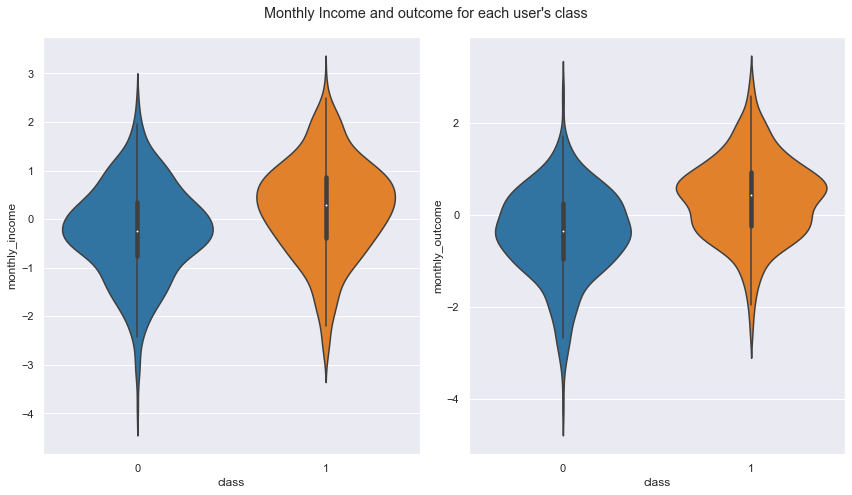

In [65]:
# Set up the matplotlib figure
sns.set_palette("tab10")
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharex=True)
fig.suptitle("Monthly Income and outcome for each user's class")

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_income', data=data1, showfliers=True, ax=axes[0])
#plt.show()

#plt.figure(figsize=(8, 6))
sns.violinplot(x='class', y='monthly_outcome', data=data1, showfliers=True, ax=axes[1])
#plt.show()

#axes1, axes2 = axes.ravel()
#axes1.set_ylim(0, 0.5e6) 
#axes2.set_ylim(0, 0.5e6) 

#plt.setp(axes, yticks=[])
plt.tight_layout()

In [67]:
data1[['monthly_income', 'monthly_outcome']].skew().sort_values(ascending=False)

monthly_income    -0.264397
monthly_outcome   -0.332458
dtype: float64

`data_credit_reports`

In [70]:
data_transformed[variables] = data_transformed[variables] +1

In [73]:
# Log transform multiple columns in dataframe 
data_transformed[variables] = data_transformed[variables].apply(lambda x: np.log(x))

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for i in variables:
    data_transformed[i] = scaler.fit_transform(data_transformed[[i]])


<ipython-input-78-3b0946b68c1f>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_transformed[["total_credit_payments",


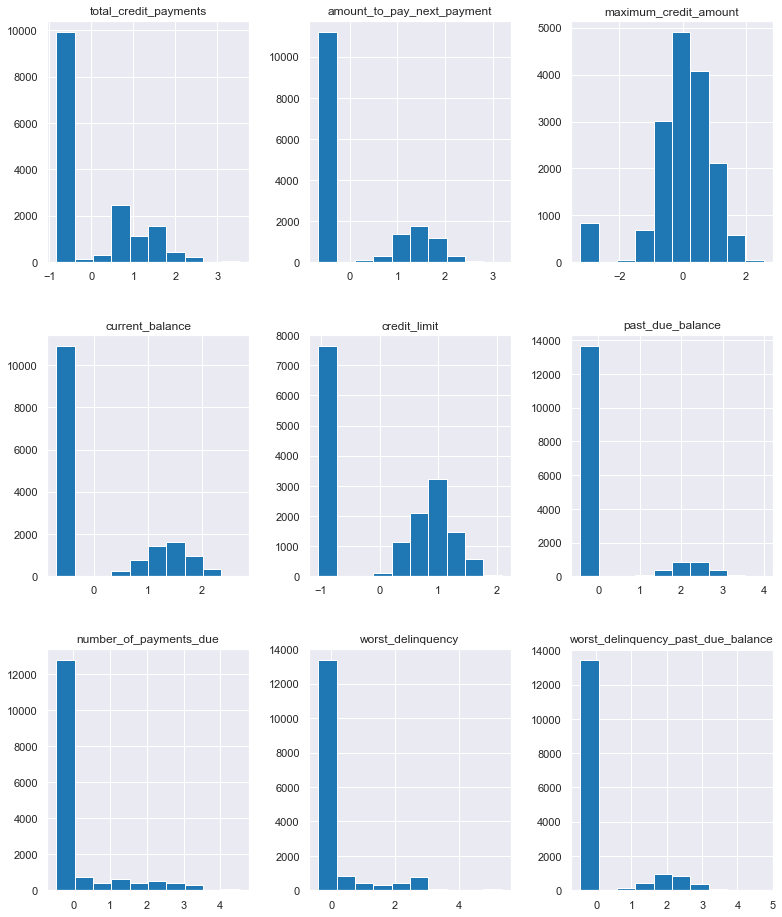

In [78]:
fig = plt.figure(figsize = (13,16))
ax = fig.gca()
#df.hist(ax = ax)
data_transformed[["total_credit_payments", 
                    "amount_to_pay_next_payment", "maximum_credit_amount", 
                    "current_balance", "credit_limit", "past_due_balance", 
                    "number_of_payments_due", "worst_delinquency",  
                    "worst_delinquency_past_due_balance"]].hist(ax=ax)
plt.show()

## Modeling

## Evaluation

## Deployment